In [1]:
from aux_func_V3 import *
import API_Numpy
import API_TensorFlow
import h5py

import dill
import seaborn
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
API=API_Numpy

WENO_Z_sim=simulation(API,
                        euler_equation,
                        WENO_Z,
                        ε=1e-40)

In [3]:
# Problema de Shock-density wave interaction
interval=10
n_pts=8000
Δx=interval/(n_pts-1)
x=np.arange(-interval/2,interval/2,Δx)
γ=1.4
CFL=0.5
FinalTime=5
BoundaryCondition=FronteiraFixa

k = 20
ρ = np.where(x < -4.5, 1.515695, 1+np.sin(k*np.pi*x)/10)
u = np.where(x < -4.5, 0.523346, 0)
p = np.where(x < -4.5, 1.805000, 1)
E = p/(γ-1)+ρ*(u**2)/2

Q0=np.stack([ρ,ρ*u,E],axis=0)

with h5py.File("data_init_shock_density.h5", "w") as hf:
    hf.create_dataset('data_init',data=Q0)

In [4]:
Q0_all=dict()
T_all=dict()
Δt_all=dict()
Δx_all=dict()
x_all=dict()

CFL = 0.5
γ   = 1.4  

############# Problema de Shock-density wave interaction #############
label='shock_density'
t_final  = 5
Δt       = 0.01
n        = 1000
interval = [-5, 5]
fator    = 8
n_ref    = n*fator

BoundaryCondition = FronteiraFixa

Δx     = (interval[1]-interval[0])/n
Δx_ref = (interval[1]-interval[0])/n_ref

x     = tf.range(interval[0], interval[1], Δx    , dtype=float_pres)
x_ref = tf.range(interval[0], interval[1], Δx_ref, dtype=float_pres)

k = 20
ρ = np.where(x_ref < -4.5, 1.515695, 1+np.sin(k*np.pi*x_ref)/10)
u = np.where(x_ref < -4.5, 0.523346, 0)
p = np.where(x_ref < -4.5, 1.805000, 1)
E = p/(γ-1)+ρ*(u**2)/2

Q0=np.stack([ρ,ρ*u,E],axis=0)

with h5py.File(f"data_init_{label}.h5", "w") as hf:
    hf.create_dataset('data_init',data=Q0)

Q0_all[label]=Q0.copy()
T_all[label]=t_final
Δt_all[label]=Δt
Δx_all[label]=Δx_ref
x_all[label]=x_ref

#######################################################################

########################### Problema de Lax ###########################
label='Lax'
t_final  = 0.13
Δt       = 0.001
n        = 200
interval = [-0.5, 0.5]
fator    = 40
n_ref    = n*fator
BoundaryCondition = FronteiraFixa

Δx     = (interval[1]-interval[0])/n
Δx_ref = (interval[1]-interval[0])/n_ref

x     = tf.range(interval[0], interval[1], Δx    , dtype=float_pres)
x_ref = tf.range(interval[0], interval[1], Δx_ref, dtype=float_pres)

ρ = np.where(x_ref < 0, 0.445, 0.5)
u = np.where(x_ref < 0, 0.698, 0.0)
p = np.where(x_ref < 0, 3.528, 0.5710)
E = p/(γ-1)+ρ*(u**2)/2

Q0=np.stack([ρ,ρ*u,E],axis=0)

with h5py.File(f"data_init_{label}.h5", "w") as hf:
    hf.create_dataset('data_init',data=Q0)

Q0_all[label]=Q0.copy()
T_all[label]=t_final
Δt_all[label]=Δt
Δx_all[label]=Δx_ref
x_all[label]=x_ref

#######################################################################

########################### Problema de Sod ###########################
label='Sod'
t_final  = 2
Δt       = 0.01
n        = 200
interval = [-5, 5]
fator    = 40
n_ref    = n*fator

BoundaryCondition = FronteiraFixa

Δx     = (interval[1]-interval[0])/n
Δx_ref = (interval[1]-interval[0])/n_ref

x     = tf.range(interval[0], interval[1], Δx    , dtype=float_pres)
x_ref = tf.range(interval[0], interval[1], Δx_ref, dtype=float_pres)

ρ = np.where(x_ref < 0, 0.125, 1)
u = x_ref-x_ref
p = np.where(x_ref < 0, 0.1  , 1)
E = p/(γ-1)+ρ*(u**2)/2

Q0=np.stack([ρ,ρ*u,E],axis=0)

with h5py.File(f"data_init_{label}.h5", "w") as hf:
    hf.create_dataset('data_init',data=Q0)

Q0_all[label]=Q0.copy()
T_all[label]=t_final
Δt_all[label]=Δt
Δx_all[label]=Δx_ref
x_all[label]=x_ref

#######################################################################

In [5]:
Q_all={}
for label in ('shock_density','Lax','Sod'):
    Δt=Δt_all[label]
    Δx=Δx_all[label]
    t_final=T_all[label]
    Q=np.zeros([int(t_final/Δt)+2,Q0.shape[0],Q0.shape[1]])
    t=0
    count=1
    Q1=np.expand_dims(Q0_all[label].copy(),axis=0)
    Q[0]=Q1.copy()
    while t<t_final:
        Q1=WENO_Z_sim.Sim(Q1, Δt, Δx, CFL, BoundaryCondition)
        Q[count]=Q1[0].copy()
        t+=Δt
        count+=1
        print(str(t)+'                                                     ',end='\r')
    Q_all[label]=Q.copy()

In [5]:
Q_all={}
for label in ('shock_density','Lax','Sod'):
    Δt=Δt_all[label]
    Δx=Δx_all[label]
    t_final=T_all[label]
    Q1=np.expand_dims(Q0_all[label].copy(),axis=0)
    Q1=WENO_Z_sim.Sim(Q1, t_final, Δx, CFL, BoundaryCondition)
    Q_all[label]=Q1.copy()

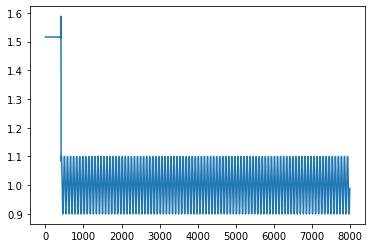

KeyboardInterrupt: 

In [31]:
import time
for i in range(500):
    plt.plot(Q_all['shock_density'][i,0])
    plt.show()
    time.sleep(1)
    clear_output()

In [28]:
with h5py.File("data_t_shock_density.h5", "r") as hf:
   Q_julia=np.asarray(hf['data'])

In [8]:
Q.shape

(1, 3, 8000)

In [41]:
np.max(np.abs(Q_julia[-2,0]-Q[-1,0]))

0.0011676463649685775

shock_density
8.664269302016692e-11


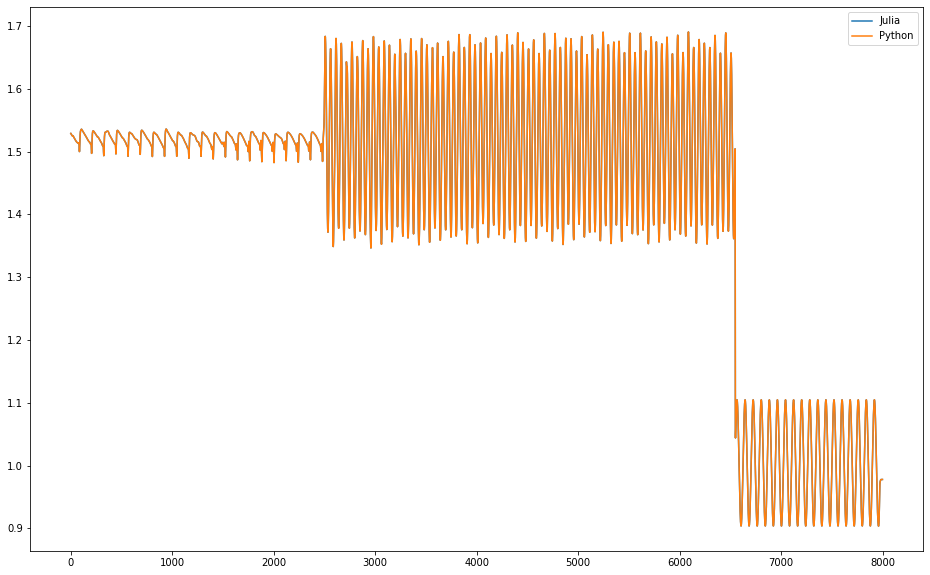

Lax
1.2499421131462185e-06


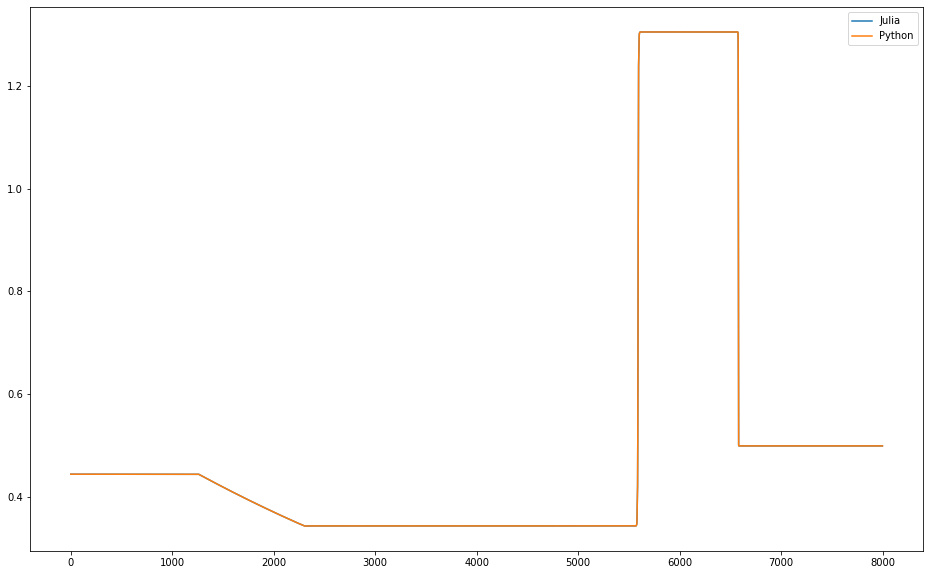

Sod
1.870212873456012e-10


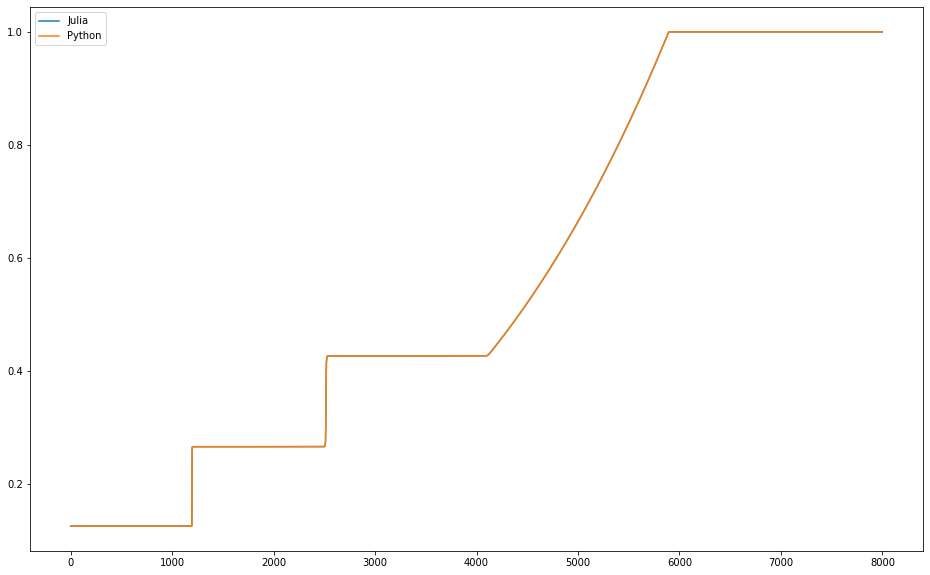

In [13]:
for label in ('shock_density','Lax','Sod'):
   print(label)
   with h5py.File(f"data_t_full_{label}.h5", "r") as hf:
      Q_julia=np.asarray(hf['data'])
   Q=Q_all[label]
   print(np.max(np.abs(Q_julia[0]-Q[-1,0])))

   plt.figure(figsize=(16,10))
   plt.plot(Q_julia[0,:],label='Julia')
   plt.plot(Q[-1,0,:],label='Python')
   plt.legend()
   plt.show()

In [18]:
print(8000*((-1.8+5)/10))
print(8000*((-1.5+5)/10))

2560.0
2800.0


shock_density
8.664269302016692e-11


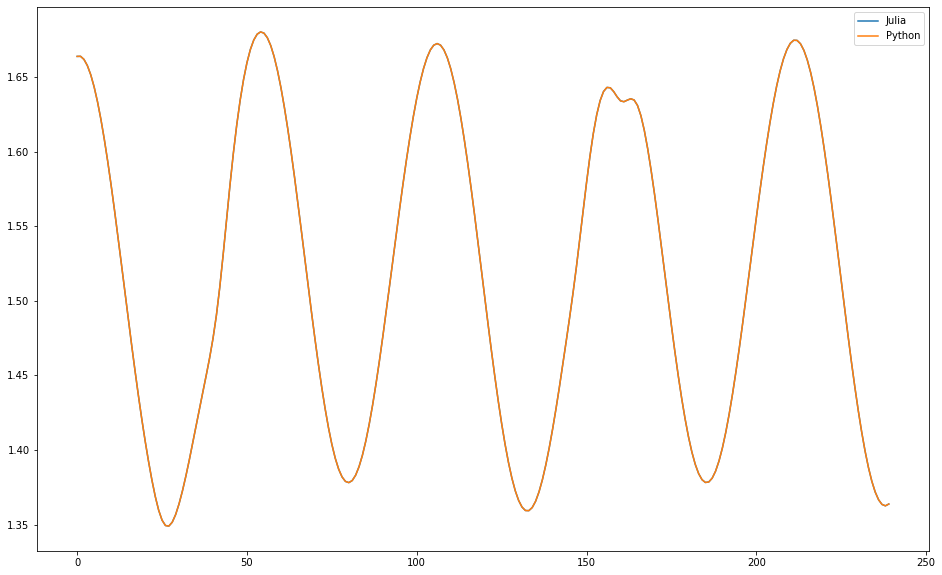

Lax
1.2499421131462185e-06


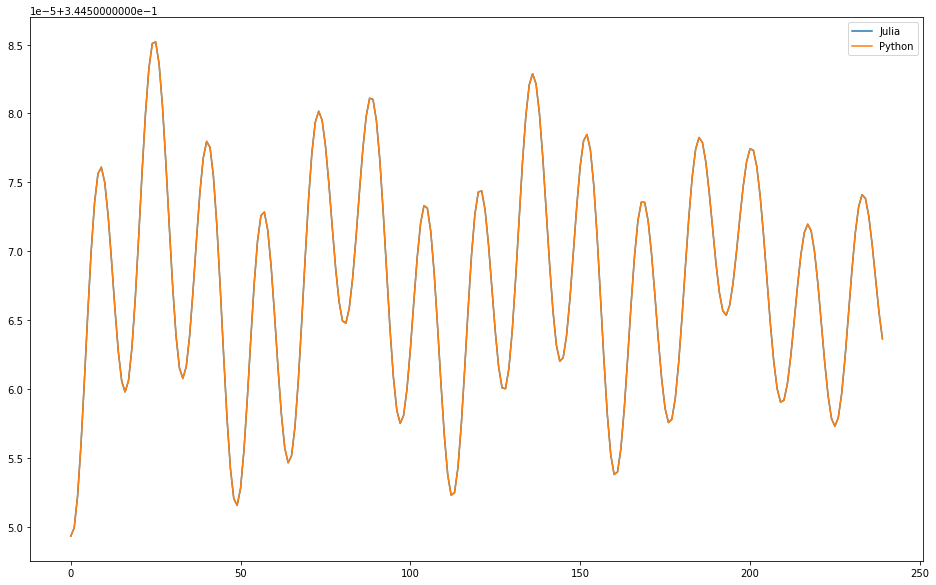

Sod
1.870212873456012e-10


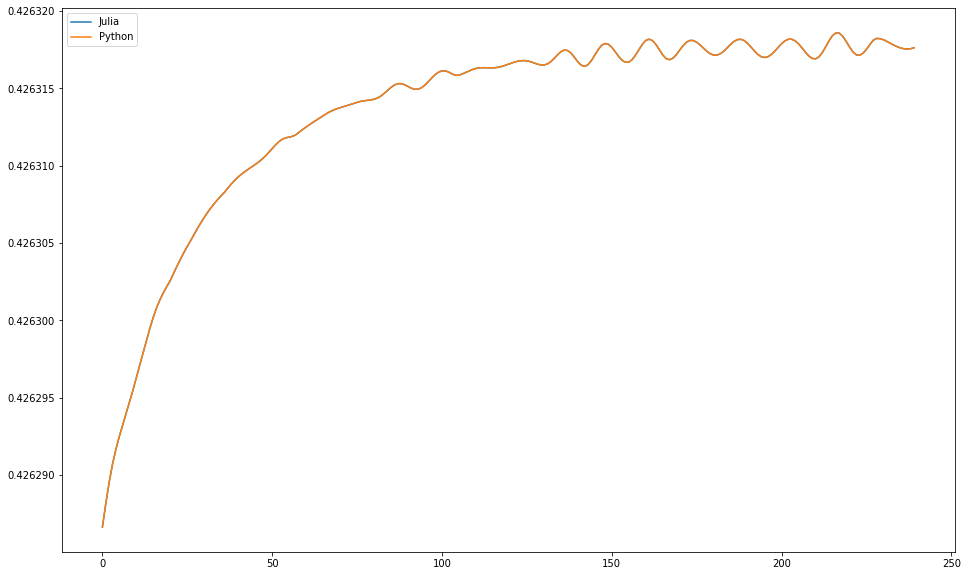

In [19]:
for label in ('shock_density','Lax','Sod'):
   print(label)
   with h5py.File(f"data_t_full_{label}.h5", "r") as hf:
      Q_julia=np.asarray(hf['data'])
   Q=Q_all[label]
   print(np.max(np.abs(Q_julia[0]-Q[-1,0])))

   plt.figure(figsize=(16,10))
   plt.plot(Q_julia[-0,2560:2800],label='Julia')
   plt.plot(Q[-1,0,2560:2800],label='Python')
   plt.legend()
   plt.show()

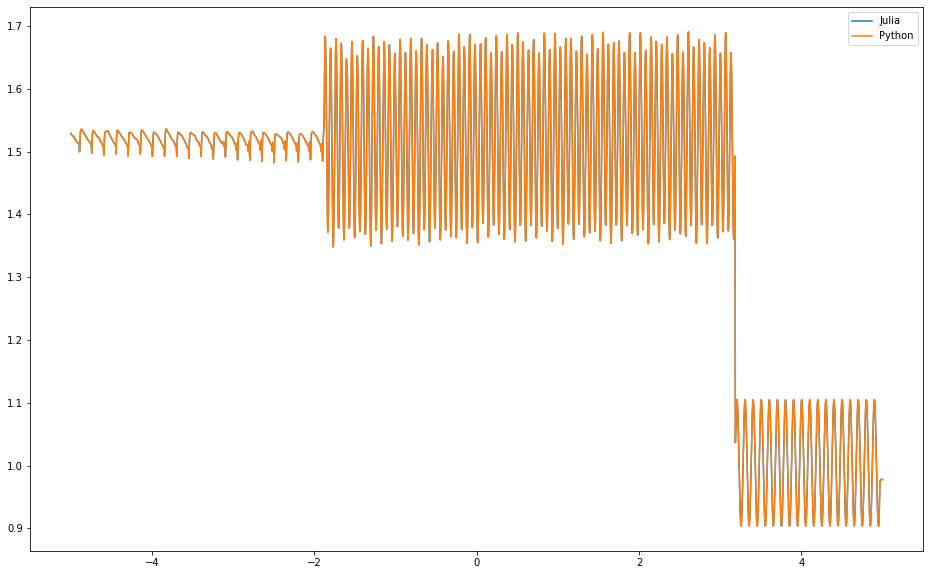

In [42]:
plt.figure(figsize=(16,10))
plt.plot(x,Q_julia[-2,0,:],label='Julia')
plt.plot(x,Q[-1,0,:],label='Python')
plt.legend()
plt.show()

In [ ]:
for name in [
    'WENO-Z',
    # 'WENO-Z+',
    # 'WENO-Z (BI)',
    # 'WENO-Z (MS)',
    # 'WENO-Z+ (MS)',
    # 'WENO-ZC (MS)',
    # 'WENO-ZC (BI)'
    ]:

    for N in (800,):
        γ = 5.0/3.0
        x, y, Δ, U0 = CondiçãoInicialRayleighTaylor_N(N, γ)

        if not(os.path.isdir(f'imagens/RT{N}-diff-CFL02-{name}-epsilon={np.log10(ɛ)}/')):
                os.mkdir(f'imagens/RT{N}-diff-CFL02-{name}-epsilon={np.log10(ɛ)}/')
        
        with open(f'imagens/RT{N}-CFL02-{name}-epsilon={np.log10(ɛ)}/data.bkp','rb') as file:
            U=dill.load(file)[:,0]

        errors=U.copy()
        
        errors=np.abs(errors-API_Numpy.reverse(errors,axis=1))

        vmax=np.max(errors)
        vmin=0

        for count,Ui in enumerate(errors):
            print(count,end='\r')
            plt.figure(figsize=(10,16))
            ref_U=Ui

            a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=vmin,vmax=vmax)
            plt.colorbar(a)
            plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=vmin,vmax=vmax,colors='black',linewidths=0.5)

            plt.ylim(ymin=0.2,ymax=0.8)
            plt.title(name)
            plt.savefig(f'imagens/RT{N}-diff-CFL02-{name}-epsilon={np.log10(ɛ)}/{str(count+1).zfill(3)}.png')
            plt.close()

<ipython-input-14-8ebd724dff24>:36: UserWarning: No contour levels were found within the data range.
  plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=vmin,vmax=vmax,colors='black',linewidths=0.5)


In [35]:
γ = 5.0/3.0
N = 400
x, y, Δ, U0 = CondiçãoInicialRayleighTaylor_N(N, γ)
cfl = 0.6
t_final = 0.1

In [36]:
WENO_Z_sim=simulation_2D(API_TensorFlow,
                        euler_equation_2D,
                        WENO_Z,
                        ε=1e-40)

In [37]:
t=0
count=0
U=U0.copy()
while t<t_final:
    Λ  = WENO_Z_sim.equation.maximum_speed(U)
    Δt = Δ*cfl/Λ
    Δt = np.where(t+Δt>t_final,t_final-t,Δt)

    U=WENO_Z_sim.Sim_step(U, Δt, Δ, Δ, RayleighTaylorGhostPointsX, RayleighTaylorGhostPointsY, RayleighTaylorGravity)
    t+=Δt
    print(t,end='\r')

In [50]:
import h5py

f = h5py.File("data_test_julia.jld", "r")
data_julia=np.asarray(f['data']).transpose((0,2,1))

2.822408973202073e-12


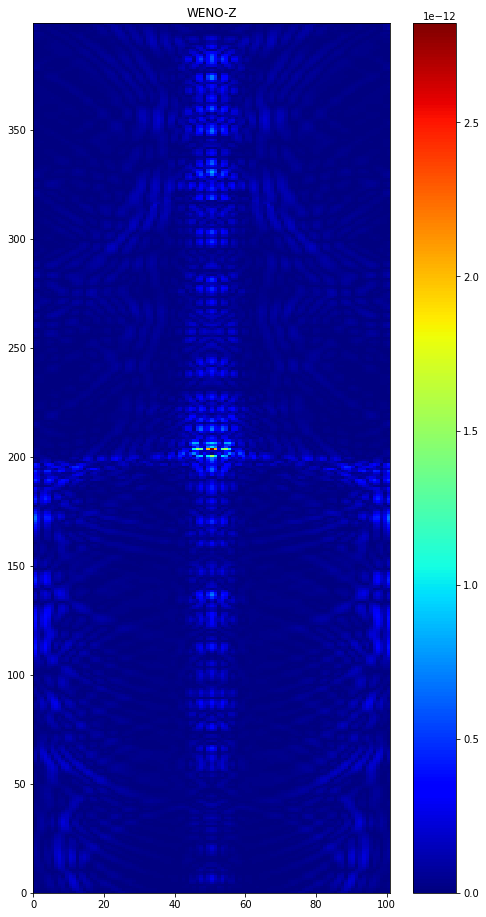

In [56]:
plt.figure(figsize=(8,16))
ref_U=np.abs(U[0]-data_julia[0])
print(np.max(ref_U))
a=plt.pcolormesh(ref_U.T,cmap='jet')
plt.colorbar(a)
plt.title('WENO-Z')
plt.show()